# Going to work as a yellow taxi driver

> Imagine that you decide to drive a taxi for 10 hours each week to earn a little extra money. Explain how you would approach maximizing your income as a taxi driver.

# Exploration

Let's explore the taxi data set, and understand what it contains, and what we might do with it...

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

In [2]:
yellow_trips = pd.read_csv("data/yellow_tripdata_2017-06.csv", parse_dates=[1,2])

In [3]:
yellow_trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-06-08 07:52:31,2017-06-08 08:01:32,6,1.03,1,N,161,140,1,7.5,1.0,0.5,1.86,0.0,0.3,11.16
1,2,2017-06-08 08:08:18,2017-06-08 08:14:00,6,1.03,1,N,162,233,1,6.0,1.0,0.5,2.34,0.0,0.3,10.14
2,2,2017-06-08 08:16:49,2017-06-08 15:43:22,6,5.63,1,N,137,41,2,21.5,1.0,0.5,0.00,0.0,0.3,23.30
3,2,2017-06-29 15:52:35,2017-06-29 16:03:27,6,1.43,1,N,142,48,1,8.5,1.0,0.5,0.88,0.0,0.3,11.18
4,1,2017-06-01 00:00:00,2017-06-01 00:03:43,1,0.60,1,N,140,141,1,4.5,0.5,0.5,2.00,0.0,0.3,7.80


In [4]:
yellow_trips.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,9656993.0,1.546961,0.497790,1.00,1.00,2.00,2.00,2.00
passenger_count,9656993.0,1.623943,1.264608,0.00,1.00,1.00,2.00,9.00
trip_distance,9656993.0,2.978617,5.704095,0.00,1.00,1.67,3.10,9496.98
RatecodeID,9656993.0,1.045527,0.566504,1.00,1.00,1.00,1.00,99.00
PULocationID,9656993.0,162.623514,66.752232,1.00,114.00,162.00,233.00,265.00
DOLocationID,9656993.0,160.737865,70.473428,1.00,107.00,162.00,233.00,265.00
payment_type,9656993.0,1.334040,0.492962,1.00,1.00,1.00,2.00,5.00
fare_amount,9656993.0,13.287274,215.167502,-550.00,6.50,9.50,15.00,630461.82
extra,9656993.0,0.341331,0.462329,-50.56,0.00,0.00,0.50,22.50
mta_tax,9656993.0,0.497225,0.076252,-0.50,0.50,0.50,0.50,140.00


## Infering Cash Tips

The data does not include tips on cash payments, so we are going to infer those as having about the same tipping rate as credit cards.

In [5]:
yellow_trips['tip_percent'] = (yellow_trips['tip_amount'] / (yellow_trips['total_amount'] - yellow_trips['tip_amount'])).clip(0, 1)

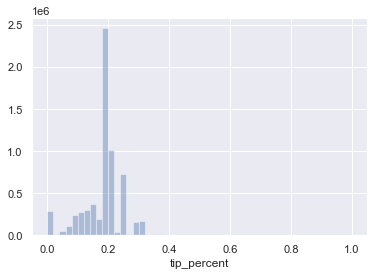

In [6]:
sns.distplot(yellow_trips.query("payment_type == 1 and total_amount > 0")['tip_percent'], kde=False)

The tip distribution is pretty narrow, and well focused around 20%. We will assume that the median tip percent for these credit card trips is also the median tip provided for cash trips.

In [7]:
median_cc_tip = yellow_trips.query('payment_type == 1 and total_amount > 0')['tip_percent'].quantile(0.5)
cash_trips = yellow_trips.eval('payment_type == 2 and total_amount > 0')
yellow_trips.loc[cash_trips, 'tip_amount'] = yellow_trips.loc[cash_trips, 'total_amount'] * median_cc_tip

## Data Transformation

Adding a few useful columns which are derived from the existing ones:

- Trip duration, to figure out how long the meter was running.
- Did the trip change taxi zones between pickup and drop-off.
- How much revenue did the trip generate for the driver, excluding the MTA tax, tolls, and the improvement surcharge. The remaining components I assume are linearly porportional to driver revenue, and therefore driver profit. There are certainly some non-linearities in this relationship, but I won't be modeling the driver's entire business model.

In [8]:
yellow_trips['trip_duration'] = pd.to_datetime(yellow_trips['tpep_dropoff_datetime']) - pd.to_datetime(yellow_trips['tpep_pickup_datetime'])
yellow_trips['delta_location'] = (yellow_trips['PULocationID'] != yellow_trips['DOLocationID']).astype(int)
yellow_trips['driver_revenue'] = yellow_trips['fare_amount'] + yellow_trips['tip_amount'] + yellow_trips['extra']

## Excluding unpaid trips

I can also exclude trips which weren't paid in cash or card, as they don't count as revenue and represent a small piece of the data which I can't account for. I could include "No Charge" trips, as those might represent times when a driver decided not to charge the riders (many of those trips include non-zero `total_amount` columns, but for this analysis, I'm choosing to infer that I'm a perfect driver, nothing is ever my fault, and I'll give myself the optimism of always charging for trips. This also amounts to assuming that the likelihood of not charging for a trip is independent of the time I work, which is probably not a bad assumption.

In [9]:
yellow_trips.payment_type.value_counts(normalize=True).map("{:.1%}".format)

1    67.5%
2    31.8%
3     0.5%
4     0.2%
5     0.0%
Name: payment_type, dtype: object

In [12]:
VALID_PAYMENTS = yellow_trips.payment_type.isin((1,2))
include = VALID_PAYMENTS.copy()

## Additional Outliers

Above, I have excluded trips and infered data where the data dictionary suggests that data will either be incomplete, not relevant, or where transformation was necessary to inform the dataset. In this section, I'll look for additional annomolies in the data which ought to be cleaned out.

### Some fares are very large (>$100k)

In [13]:
yellow_trips.query('fare_amount > 1_000')[['VendorID', 'trip_duration', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'fare_amount']]

,VendorID,trip_duration,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount
473417,1,0 days 00:19:15,7.00,1,264,264,8018.00
2427507,1,0 days 00:12:58,3.30,1,45,66,3010.80
2767752,1,0 days 00:00:00,0.00,1,65,264,1265.50
3527931,1,0 days 00:11:22,733.40,2,186,137,12837.45
4201741,2,2 days 21:10:40,4942.40,1,193,193,9999.99
5203847,2,1 days 06:18:16,6545.78,1,193,193,9999.99
5640037,2,1 days 19:58:11,9496.98,1,193,193,9999.99
5773420,1,0 days 00:04:18,0.80,1,141,141,630461.82
6007639,1,0 days 00:27:35,0.00,1,158,161,218316.30
9218988,2,0 days 17:46:52,4208.94,1,193,193,9999.99


These trips fall into three categories
1. long trips which took a long time
2. short trips which have very little recorded distance and a very short duration but a high fare.
3. trips which have a fare of exactly 9999.99, which is probably indicative of a missing value. These trips have vendorID = 2

I've chosen to discard category (3) trips, as they look like likely errors or cases where the fare can't actually be recorded. Also, even if they were real, when deciding when and how to work betting on $10,000 trips isn't a great idea.

In [14]:
V2_OUT_OF_BOUNDS = 'VendorID == 2 and fare_amount == 9999.99'
yellow_trips.query(V2_OUT_OF_BOUNDS)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tip_percent,trip_duration,delta_location,driver_revenue
4201741,2,2017-06-16 11:47:32,2017-06-19 08:58:12,1,4942.40,1,N,193,193,2,...,0.0,0.0,1997.334887,0.0,0.0,9999.99,0.0,2 days 21:10:40,0,11997.324887
5203847,2,2017-06-19 09:02:27,2017-06-20 15:20:43,1,6545.78,1,N,193,193,2,...,0.0,0.0,1997.334887,0.0,0.0,9999.99,0.0,1 days 06:18:16,0,11997.324887
5640037,2,2017-06-20 15:21:21,2017-06-22 11:19:32,1,9496.98,1,N,193,193,2,...,0.0,0.0,1997.334887,0.0,0.0,9999.99,0.0,1 days 19:58:11,0,11997.324887
9218988,2,2017-06-09 16:01:22,2017-06-10 09:48:14,1,4208.94,1,N,193,193,2,...,0.0,0.0,1997.334887,0.0,0.0,9999.99,0.0,0 days 17:46:52,0,11997.324887


These four trips appear to have exceeded the fare the meter can report. We could leave them in the data set in the hopes that they indicate where we might pick up very long trips, as they appear to only be truncated.

Removing them from the dataset arguably makes the truncation worse, as the expected value of trips will decrease.

However, we only really want to work for 10 hours per week, so excluding them might help us find times where we don't have to go on 2 day, 21 hour taxi trips.

For category (2), we can exclude any trip with 0 distance and 0 duration on the taxi meter as likely erroneous data.

In [15]:
yellow_trips[VALID_PAYMENTS].query('trip_duration.dt.seconds < 1 and trip_distance < 0.01').describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,8793,1.03378,0.180665,1,1,1,1,2
passenger_count,8793,1.22097,0.663083,0,1,1,1,6
trip_distance,8793,0,0,0,0,0,0,0
RatecodeID,8793,3.26862,13.4456,1,1,1,1,99
PULocationID,8793,166.985,68.7709,1,132,162,234,265
DOLocationID,8793,261.224,19.2446,1,264,264,264,265
payment_type,8793,1.95326,0.211097,1,2,2,2,2
fare_amount,8793,14.2739,26.9936,0,2.5,6.5,15,1265.5
extra,8793,0.313239,0.565239,-0.45,0,0,0.5,7.06
mta_tax,8793,0.492784,1.96118,0,0.5,0.5,0.5,140


There is quite a bit of data here (almost 9000 trips), but it contains an error somewhere (no distance or time) and represents only 0.1% of trips taken, so we should feel okay excluding them. With more work, we could try to infer the correct values (e.g. inferring distance using the pick up and drop off locations)

In [16]:
VERY_SHORT_TRIPS = 'trip_duration.dt.seconds < 1 and trip_distance < 0.01'
print("{0:.4%}".format(yellow_trips[VALID_PAYMENTS].eval('trip_duration.dt.seconds < 1 and trip_distance < 0.01').mean()))

0.0917%


In [17]:
include &= ~(yellow_trips.eval(VERY_SHORT_TRIPS) | yellow_trips.eval(V2_OUT_OF_BOUNDS))

In [18]:
yellow_trips[include].query('fare_amount > 500')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tip_percent,trip_duration,delta_location,driver_revenue
382322,2,2017-06-01 13:02:47,2017-06-01 13:02:53,5,0.00,5,N,264,264,2,...,0.80,0.50,196.857523,0.00,0.3,985.60,0.0,00:00:06,0,1181.657523
473417,1,2017-06-11 01:21:35,2017-06-11 01:40:50,1,7.00,1,N,264,264,2,...,-50.56,51.36,1601.624501,0.00,0.0,8018.80,0.0,00:19:15,0,9569.064501
1507210,1,2017-06-04 10:43:03,2017-06-04 14:38:27,1,221.00,1,N,236,265,2,...,0.00,0.50,114.659121,5.76,0.3,574.06,0.0,03:55:24,1,682.159121
1871258,2,2017-06-05 06:01:51,2017-06-05 06:01:51,1,15.97,1,N,24,26,2,...,0.50,0.50,185.512650,0.00,0.3,928.80,0.0,00:00:00,1,1113.512650
2427507,1,2017-06-08 11:14:26,2017-06-08 11:27:24,1,3.30,1,N,45,66,2,...,-31.61,32.41,601.517976,0.00,0.0,3011.60,0.0,00:12:58,1,3580.707976
3214760,2,2017-06-13 17:09:42,2017-06-14 10:32:06,2,0.00,1,N,151,151,2,...,1.00,0.50,105.699068,0.00,0.3,529.20,0.0,17:22:24,0,630.199068
3544341,2,2017-06-14 15:14:48,2017-06-14 18:44:54,1,124.64,4,N,132,265,2,...,0.00,0.50,117.902796,0.00,0.3,590.30,0.0,03:30:06,1,707.402796
5773420,1,2017-06-20 22:34:58,2017-06-20 22:39:16,1,0.80,1,N,141,141,2,...,0.50,0.50,125924.724368,0.00,0.3,630463.12,0.0,00:04:18,0,756387.044368
6007639,1,2017-06-21 16:58:30,2017-06-21 17:26:05,1,0.00,1,N,158,161,2,...,0.49,0.00,43605.277630,0.00,0.3,218317.09,0.0,00:27:35,1,261922.067630
6294990,2,2017-06-22 12:56:16,2017-06-22 12:56:32,2,0.00,5,N,223,223,2,...,0.00,0.00,109.913449,0.00,0.3,550.30,0.0,00:00:16,0,659.913449


There are only 2 trips which cost more than $10,000, and both look suspicious (short durations and short distances. I'll exclude any trip which costs more than that.

In [19]:
EXPENSIVE_TRIPS = yellow_trips.eval("total_amount > 10_000")
include &= ~EXPENSIVE_TRIPS

In [21]:
yellow_trips['trip_duration_s'] = yellow_trips['trip_duration'].dt.seconds + yellow_trips['trip_duration'].dt.days * 24 * 60 * 60

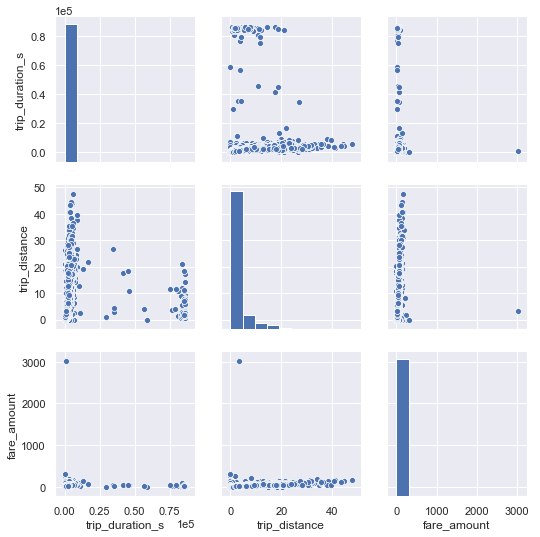

In [22]:
sns.pairplot(yellow_trips[include][['trip_duration_s', 'trip_distance', 'fare_amount']].sample(100_000))

Some of these outliers seem really large. I can estimate what the fare should have been based on the NYC TLC website's fare descriptor. We'll ignore anything complicated, and just use this to see if we can define what an outlier is in terms of trips that took longer than 60s or went further than 0.2 miles. For trips shorter than both of those, we'll also look at the fare distribution, and understand if there are problems in the data there.

### Long trip fare estimation

In [23]:
LONG_TRIPS = yellow_trips.eval('trip_distance > 0.2 or trip_duration_s > 60')

In [24]:
yellow_trips['estimated_fare'] = 2.5 + (yellow_trips['trip_distance'] / 5) * 0.5 + ((yellow_trips['trip_duration'].dt.seconds + yellow_trips['trip_duration'].dt.days * 24 * 60) / 60) * 0.5

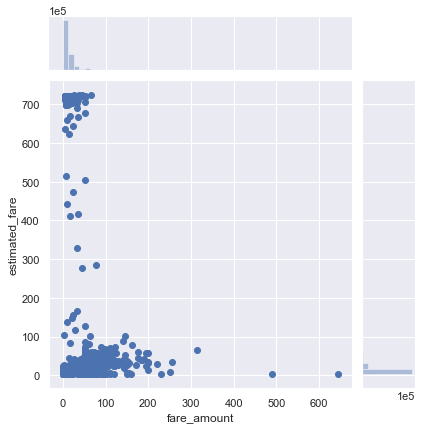

In [25]:
sns.jointplot(data=yellow_trips[LONG_TRIPS & include].sample(100_000), x='fare_amount', y='estimated_fare')

Since I only want to drive a taxi for 10 hours a week, lets exclude these really long taxi sessions from our data.

I could identify them in a principled way (e.g. % error between estimated fare and actual fare), but for now, I'll take a short cut and just eliminate trips longer than 10 hours

In [26]:
LONG_DURATION_TRIPS = (yellow_trips.trip_duration.dt.seconds >= (10 * 60 * 60)) | (yellow_trips.trip_duration.dt.days > 1)

In [27]:
include &= ~LONG_DURATION_TRIPS

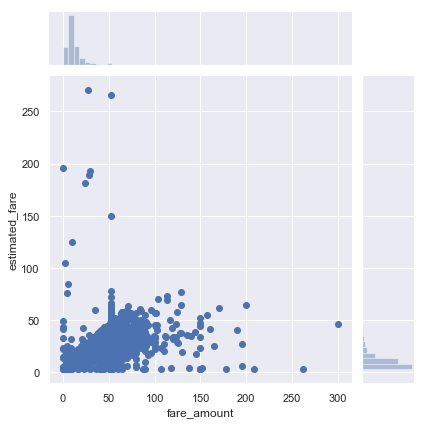

In [28]:
sns.jointplot(data=yellow_trips[LONG_TRIPS & include].sample(100_000), x='fare_amount', y='estimated_fare')

This looks decent. Let's take one last look at the overall distributions

In [30]:
yellow_trips[include].describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,9.56556e+06,1.55016,0.497478,1,1,2,2,2
passenger_count,9.56556e+06,1.62637,1.26703,0,1,1,2,9
trip_distance,9.56556e+06,2.97785,3.78068,0,1,1.68,3.1,770
RatecodeID,9.56556e+06,1.04185,0.340723,1,1,1,1,99
PULocationID,9.56556e+06,162.652,66.736,1,114,162,233,265
DOLocationID,9.56556e+06,160.684,70.4207,1,107,162,233,265
payment_type,9.56556e+06,1.31987,0.466425,1,1,1,2,2
fare_amount,9.56556e+06,13.1941,11.9486,-52,6.5,9.5,15,8018
extra,9.56556e+06,0.341616,0.461339,-50.56,0,0,0.5,22.5
mta_tax,9.56556e+06,0.497849,0.0384374,-0.5,0.5,0.5,0.5,51.36


Some trips still have a negative driver revenue amount – those are probably indicative of something stragne in the data, and I'll exclude them.

In [32]:
NO_REVENUE = yellow_trips['driver_revenue'] <= 0
include &= ~NO_REVENUE

In [36]:
print("{:.1%}".format(include.mean()))

99.0%


In this process, I cleaned the dataset, and ended up excluding 1% of trips overall.

I'm going to save this data for easy re-processing later, after dropping the estimated fare (I'll use the actual value going forward)

_I'm using a pickle, because although its not particularily efficient or portable, it is a quick way to recover the work done above without re-computing anything_

In [41]:
yellow_trips[include].drop('estimated_fare', axis=1).to_pickle("data/yellow_tripdata_2017-06.cleaned.pkl", compression="gzip")

# Estimating Revenue

As a first pass estimate, I'll look at revenue per second, by hour, folded over the course of a week. This will help predict when profitible work times might occur. There is a weakness, though, and that is that revenue is only captured here when the meter is running.

In [ ]:
yellow_trips = pd.read_pickle("data/yellow_tripdata_2017-06.cleaned.pkl")